In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from scipy.spatial.distance import jensenshannon
import numpy as np
import math
import random
import numpy as np
import torch

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from xgboost import XGBRegressor
from tvae_only_project.tvae import TVAE

In [2]:
data = pd.read_csv("train_data_tvae.csv")
model_path = "tvae_synthesizer.pkl"    
model = TVAE.load(model_path)

In [3]:
data = data[data['regular'] != 100]


In [4]:


def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False



In [5]:
seed_everything(123)
pr_test = 0.3
synthetic_data = model.sample(int(len(data)*(1-pr_test)))
synthetic_data.head()

,Lane number,business,senior,family,young,PRM,regular,Experience,Number of boxes,Group size,delta_time,ETD
0,3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,205.165358,0
1,3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0,354.485734,0
2,2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,4.0,319.203116,0
3,3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,133.205742,0
4,3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,4.0,4209.622297,0


In [6]:
# Filter rows where 'regular' != 100
data = data[data['regular'] != 100]
synthetic_data = synthetic_data[synthetic_data['regular'] != 100]

data = data.rename(columns={'delta_time': 'waiting_time'})
synthetic_data = synthetic_data.rename(columns={'delta_time': 'waiting_time'})




In [7]:
# compare_distributions(data, synthetic_data)

In [8]:
def compare_distributions(real_df, synthetic_df, categorical_columns=None, continuous_columns=None, n_rows=3):
    """
    Compare distributions of real and synthetic data, arranged in `n_rows` of subplots.
    
    Args:
        real_df (pd.DataFrame): Real dataset.
        synthetic_df (pd.DataFrame): Synthetic dataset.
        categorical_columns (list of str, optional): List of categorical column names.
        continuous_columns (list of str, optional): List of continuous column names.
        n_rows (int, optional): Number of subplot rows. Default is 3.
    """
    if categorical_columns is None:
        categorical_columns = [col for col in real_df.columns if real_df[col].nunique() < 20]
    if continuous_columns is None:
        continuous_columns = [col for col in real_df.columns if col not in categorical_columns]

    # Order columns: continuous first, then categorical
    columns = continuous_columns + categorical_columns
    total = len(columns)
    n_cols = math.ceil(total / n_rows)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for idx, col in enumerate(columns):
        ax = axes[idx]

        if col in categorical_columns:
            real_counts = real_df[col].value_counts(normalize=True).sort_index()
            synth_counts = synthetic_df[col].value_counts(normalize=True).sort_index()

            categories = sorted(set(real_counts.index).union(set(synth_counts.index)))
            real_vals = [real_counts.get(cat, 0) for cat in categories]
            synth_vals = [synth_counts.get(cat, 0) for cat in categories]

            x = np.arange(len(categories))
            width = 0.35
            ax.bar(x - width/2, real_vals, width, label='Real', alpha=0.6)
            ax.bar(x + width/2, synth_vals, width, label='Synthetic', alpha=0.6)
            ax.set_xticks(x)
            ax.set_xticklabels(categories, rotation=45)

            jsd = jensenshannon(real_vals, synth_vals)
            ax.set_title(f'{col} (Categorical)\nJSD: {jsd:.4f}')
        else:
            sns.kdeplot(real_df[col], label='Real', fill=True, ax=ax)
            sns.kdeplot(synthetic_df[col], label='Synthetic', fill=True, ax=ax)
            stat, pval = ks_2samp(real_df[col], synthetic_df[col])
            ax.set_title(f'{col} (Continuous)\nKS p-val: {pval:.4f}')

        ax.legend()

    # Hide any unused subplots
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


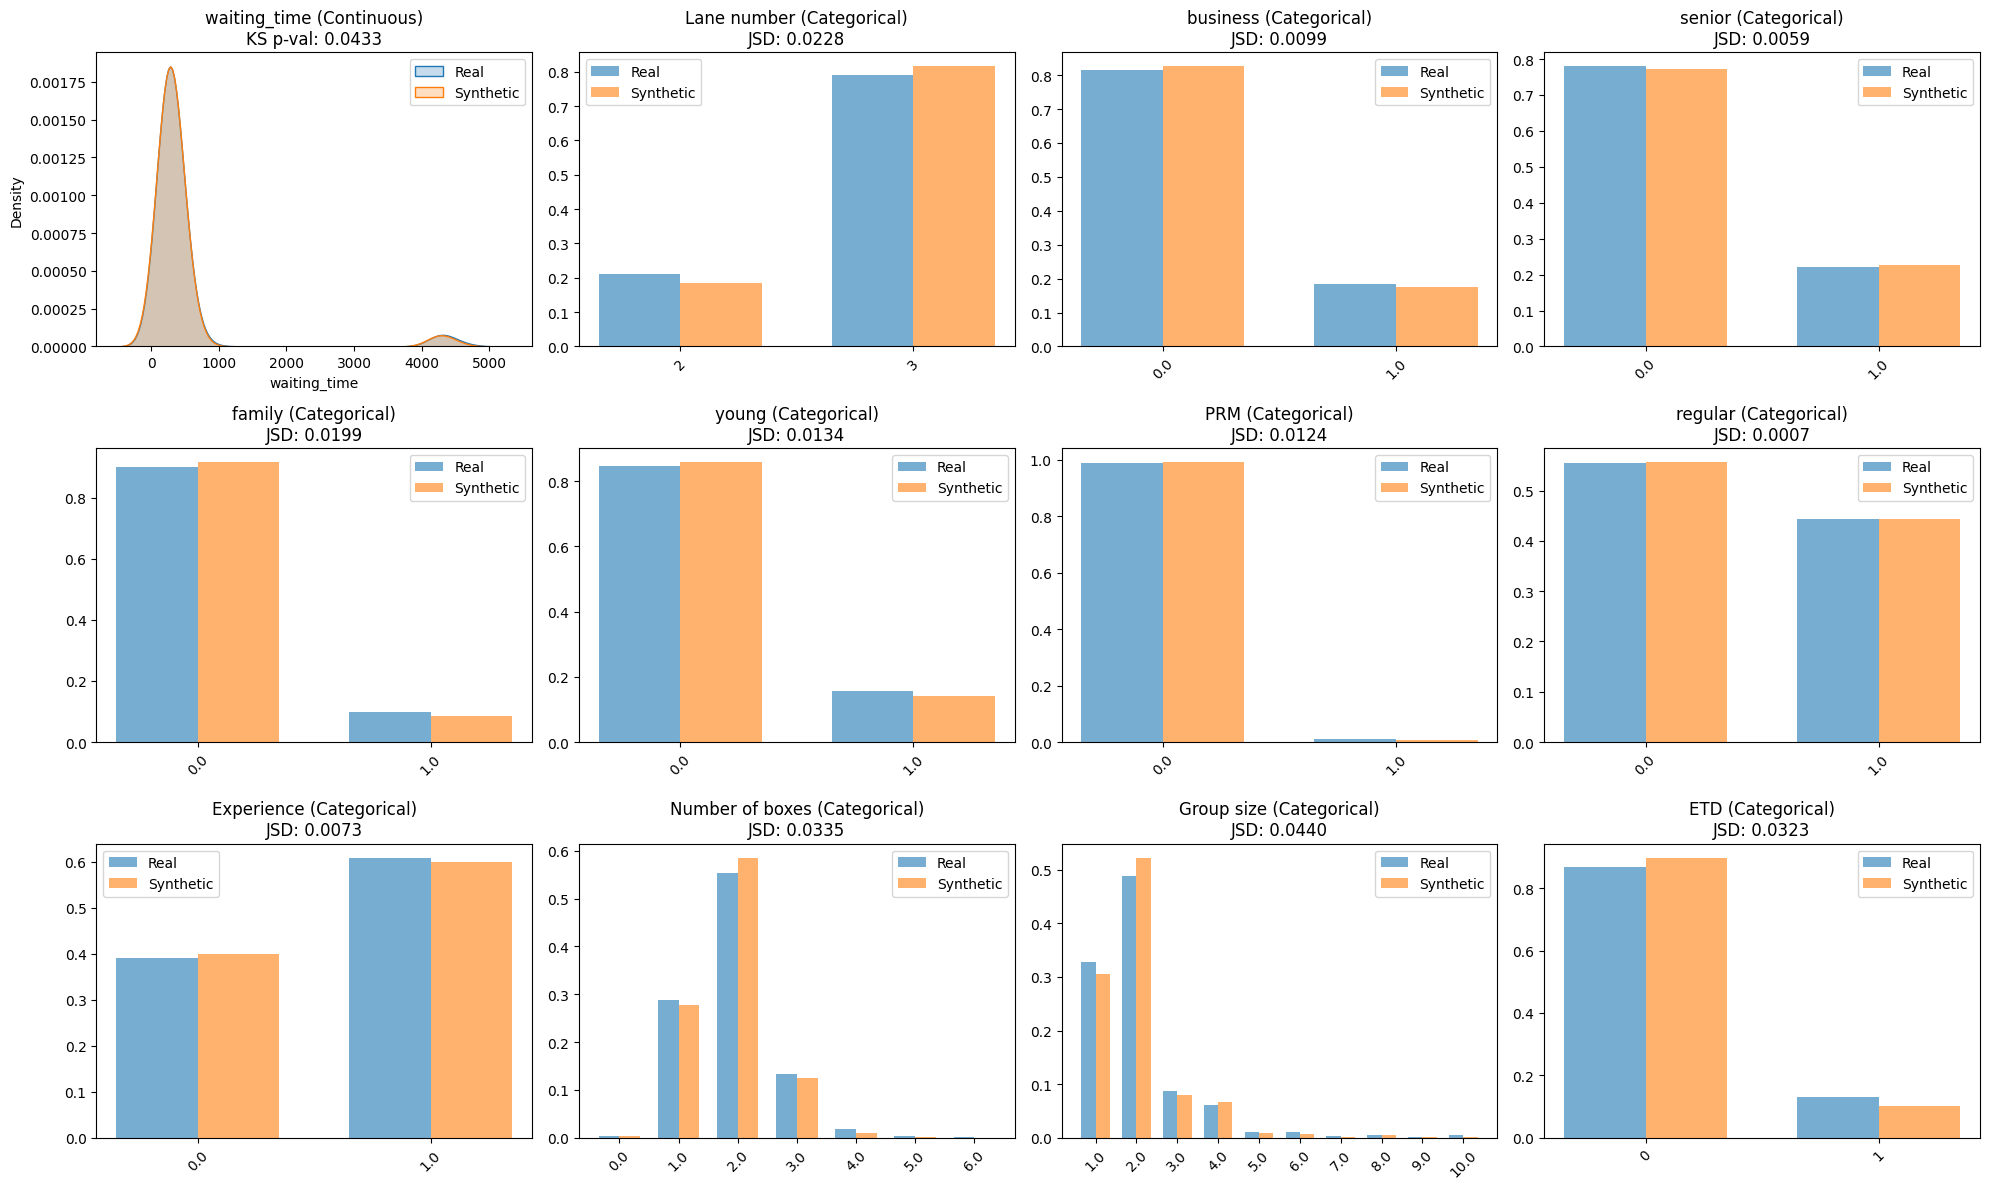

In [9]:
compare_distributions(data, synthetic_data)

In [10]:


def evaluate_synthetic_regression(
    real_df,
    synthetic_df,
    target_col='target',
    test_size=0.2,
    random_state=42,
    plot=True,
    model_type='rf',  # 'rf' for RandomForest, 'xgb' for XGBoost
    model_params=None
):
    """
    Evaluate and plot regression performance for:
    1. Train on real only
    2. Train on synthetic only
    3. Train on real + synthetic

    Args:
        real_df (pd.DataFrame): Real dataset with target.
        synthetic_df (pd.DataFrame): Synthetic dataset with target.
        target_col (str): Name of the target column.
        test_size (float): Fraction of real data to use for testing.
        random_state (int): Reproducibility seed.
        plot (bool): If True, shows plots of true vs predicted target values.
        model_type (str): 'rf' for RandomForest, 'xgb' for XGBoost.
        model_params (dict): Optional custom parameters for the model.

    Returns:
        pd.DataFrame: Table with MSE, RMSE, MAE, and R² for each strategy.
    """
    if model_params is None:
        model_params = {}

    # Split real data
    train_real, test_real = train_test_split(real_df, test_size=test_size, random_state=random_state)
    X_train_real = train_real.drop(columns=target_col)
    y_train_real = train_real[target_col]
    X_test_real = test_real.drop(columns=target_col)
    y_test_real = test_real[target_col]

    # Synthetic data
    X_train_synth = synthetic_df.drop(columns=target_col)
    y_train_synth = synthetic_df[target_col]

    # Combine real + synthetic
    X_train_combined = pd.concat([X_train_real, X_train_synth], axis=0).reset_index(drop=True)
    y_train_combined = pd.concat([y_train_real, y_train_synth], axis=0).reset_index(drop=True)

    strategies = {
        'Real Only': (X_train_real, y_train_real),
        'Synthetic Only': (X_train_synth, y_train_synth),
        'Real + Synthetic': (X_train_combined, y_train_combined)
    }

    results = []
    preds_dict = {}

    def get_model():
        if model_type == 'xgb':
            return XGBRegressor(random_state=random_state, verbosity=0, **model_params)
        else:
            return RandomForestRegressor(random_state=random_state, **model_params)

    for name, (X_train, y_train) in strategies.items():
        model = get_model()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test_real)

        mse = mean_squared_error(y_test_real, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test_real, y_pred)
        r2 = r2_score(y_test_real, y_pred)
        
        if r2 < 0:
            print(f"Warning: Negative R² ({r2:.3f}) for strategy '{name}'.")

        results.append({
            'Training Source': name,
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R²': r2
        })
        preds_dict[name] = y_pred

    results_df = pd.DataFrame(results)

    if plot:
        plt.figure(figsize=(16, 4))
        for idx, (name, y_pred) in enumerate(preds_dict.items()):
            plt.subplot(1, 3, idx + 1)
            plt.plot(y_test_real.values, color='red', label='Real', alpha=0.6)
            plt.plot(y_pred, color='blue', label='Predicted', alpha=0.6)
            plt.xlabel('Sample Index')
            plt.ylabel('Target Value')
            plt.title(name)
            plt.legend()
            plt.grid(True)
        plt.tight_layout()
        plt.show()

    return results_df


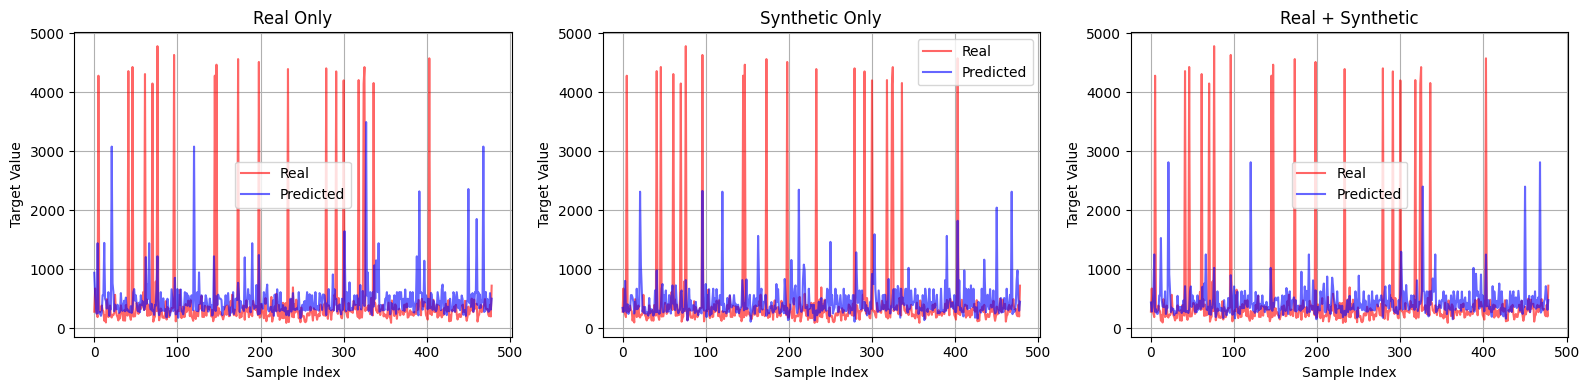

    Training Source            MSE        RMSE         MAE        R²
0         Real Only  796349.393628  892.384107  377.872409 -0.167846
1    Synthetic Only  705878.859291  840.165971  351.822600 -0.035171
2  Real + Synthetic  743597.470207  862.320979  356.601473 -0.090485


In [11]:
real_df = data
synthetic_df = synthetic_data
results = evaluate_synthetic_regression(real_df, synthetic_df, target_col='waiting_time', model_type='rf')
print(results)


In [12]:
import pandas as pd
from docx import Document

# Convert to DataFrame
df = pd.DataFrame(results)

# Create Word document
doc = Document()
doc.add_heading("Regression Performance Summary", level=1)

# Add table
table = doc.add_table(rows=1, cols=len(df.columns))
table.style = 'Table Grid'

# Add header
hdr_cells = table.rows[0].cells
for i, column_name in enumerate(df.columns):
    hdr_cells[i].text = column_name

# Add data rows
for _, row in df.iterrows():
    row_cells = table.add_row().cells
    for i, item in enumerate(row):
        row_cells[i].text = f"{item:,.4f}" if isinstance(item, float) else str(item)

# Save document
doc.save("regression_results.docx")


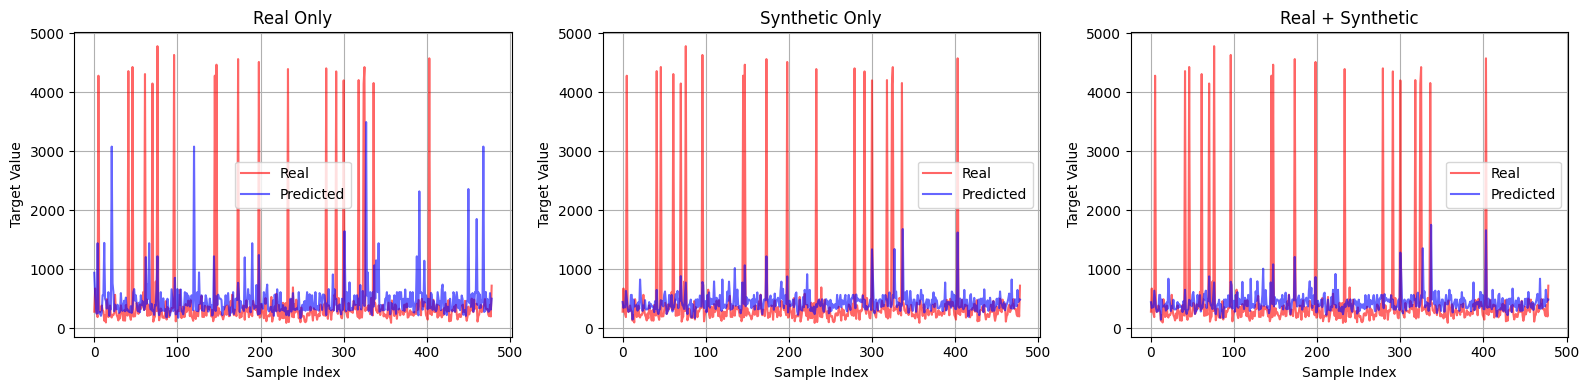

    Training Source            MSE        RMSE         MAE        R²
0         Real Only  796349.393628  892.384107  377.872409 -0.167846
1    Synthetic Only  610730.301629  781.492355  313.062466  0.104365
2  Real + Synthetic  612015.462239  782.314171  313.584763  0.102480


In [13]:
n_synth = len(data)*100
synth_enhanced = model.sample(n_synth)
synth_enhanced = synth_enhanced.rename(columns={'delta_time': 'waiting_time'})
results_enhanced = evaluate_synthetic_regression(real_df, synth_enhanced, target_col='waiting_time', model_type='rf')
# results_enhanced = evaluate_synthetic_regression(real_df, synth_enhanced, target_col='waiting_time', model_type='rf')
print(results_enhanced )

In [14]:
df = pd.DataFrame(results_enhanced)

# Create Word document
doc = Document()
doc.add_heading("Regression Performance Summary", level=1)

# Add table
table = doc.add_table(rows=1, cols=len(df.columns))
table.style = 'Table Grid'

# Add header
hdr_cells = table.rows[0].cells
for i, column_name in enumerate(df.columns):
    hdr_cells[i].text = column_name

# Add data rows
for _, row in df.iterrows():
    row_cells = table.add_row().cells
    for i, item in enumerate(row):
        row_cells[i].text = f"{item:,.4f}" if isinstance(item, float) else str(item)

# Save document
doc.save("regression_enhanced_results.docx")
